#### Возьмём оригинальный файл main.cpp и compile.sh.

In [1]:
from IPython.display import FileLink, FileLinks # импорт для вставки линков на файлы

In [2]:
FileLink("main.cpp")

/home/mbusel/Магистратура/Параллельные вычисления/Ex1/main.cpp

In [3]:
FileLink("compile.sh")

/home/mbusel/Магистратура/Параллельные вычисления/Ex1/compile.sh

#### Далее модифицируем скрипт запуска run.sh

In [4]:
FileLink("run.sh")

/home/mbusel/Магистратура/Параллельные вычисления/Ex1/run.sh

#### Распарсим его

In [5]:
def parse(filename):
    # from: 
    #    n = 1xxx
    #    timeSimple: %
    #    timeBlock: $
    #    timeSwapped: &
    # to:
    #    [[n, %, $, &], ...]
    result = [];
    with open(filename, 'r') as file:
        n = -1
        for line in file:    
            if 'n = ' in line:
                n = int(line.split('=')[1].strip())
                result.append([n])
            else:
                value = line.split(':')[1]
                value = float(value.strip())
                result[-1].append(value)
    return result

In [6]:
parsed_data = parse('run_log.log')

#### И построим графики зависмости времени работы различных алгоритмов в зависимости от размера матриц

In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [8]:
from matplotlib import pyplot
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5

In [9]:
def plot(data):
    titles = ['simple', 'block', 'swapped']
    xs = list(map(lambda x: x[0], data))
    for i in range(1, 4):
        pyplot.plot(xs, list(map(lambda x: x[i], data)))
    pyplot.xticks(range(xs[0], xs[-1] + 1, 4))
    pyplot.legend(titles)
    pyplot.xlabel('matrix size, n')
    pyplot.ylabel('time, s')

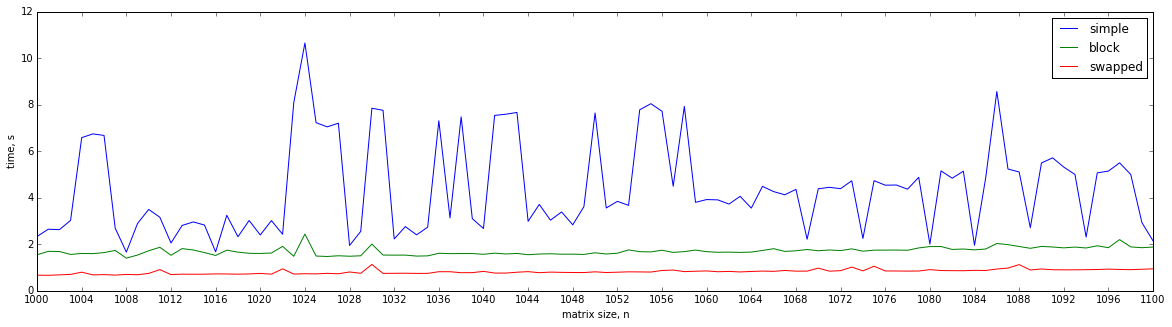

In [10]:
plot(parsed_data)

На графике можно заметить скачок при n = 1024 в методе simple. но кроме того, существует довольно большое количество скачков и при других значениях, которые довольно трудно объяснить. Частично, проблему можно решить, сгладив график - проведя несколько испытаний при различных размерах матриц и усреднив время выполнения, в файле run_avg.sh - модифицированный вариант скрипта запуска

In [11]:
FileLink("run_avg.sh")

/home/mbusel/Магистратура/Параллельные вычисления/Ex1/run_avg.sh

In [12]:
def parse_avg(filename):
    # from:
    #    #x
    #    n = 1xxx
    #    timeSimple: %
    #    timeBlock: $
    #    timeSwapped: &
    # to:
    #    [[n, avg(%), avg($), avg(&)], ...]
    result = [];
    attemptNum = 0
    index = 1
    with open(filename, 'r') as file:
        n = -1
        for line in file:
            if 'n = ' in line:
                n_new = int(line.split('=')[1].strip())
                if n_new != n:
                    if n != -1:
                        result[-1][1] /= attemptNum
                        result[-1][2] /= attemptNum
                        result[-1][3] /= attemptNum
                    n = n_new
                    result.append([n, 0.0, 0.0, 0.0])
                    attemptNum = 1
            elif line[0] == '#':
                attemptNum += 1
                index = 1
            else:
                value = line.split(':')[1]
                value = float(value.strip())
                result[-1][index] += value
                index += 1
    result[-1][1] /= attemptNum
    result[-1][2] /= attemptNum
    result[-1][3] /= attemptNum
    return result

In [13]:
parsed_data_avg = parse_avg("run_log_avg.log")

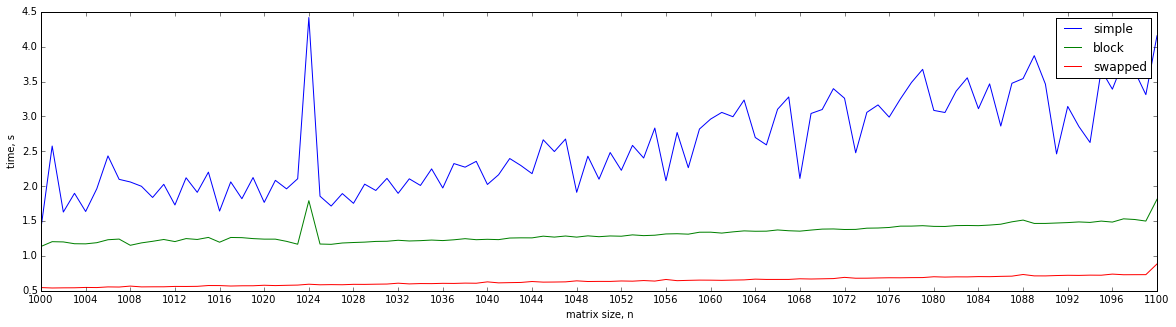

In [14]:
 plot(parsed_data_avg)

Результат заметно лучше предыдущей попытки - график выглядит более сглаженным, хотя по-прежнему у алгоритма прямого перемножения матриц график времени работы достаточно зубчатый. Во втором эксперименте общее время работы всех алгоритмов гораздо меньше, чем в первом. Это связано с отключением всех остальных служб (для чистоты эксперимента) и говорит о значительном влиянии на результаты первого запуска процессов ОС, запущенных в фоне, поэтому в выводах будем ориентироваться именно на график #2

##### Выводы по получившимся результатам


&nbsp;&nbsp;&nbsp;&nbsp;1) Существенный скачок времени выполнения наблюдается не только в simple-алгоритме, но и в алгоритме блочного перемножения матриц.
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;а) Для случая simple причины были рассмотрены на паре - учитывая, что длина линии в моём процессоре 64 байта    (2^6), то, т.к. в цикле мы перебираем элементы матрицы B по столбцам, а каждый элемент, находящийся в том же столбце имеет смещение 2^10xsizeof(float) байт = 2^12, что, учитывая размер индекса (об этом подробней в лабораторной №3), означает, что все элементы столбца попадут в один и тот же индекс кеша, т.е. мы будем вытеснять всё ещё нужные нам значения раз в канальность-процессора раз (с определением канальности возникли некоторые проблемки <a href=http://www.cpu-world.com/CPUs/Core_i7/Intel-Core%20i7-3540M%20(PGA)%20Mobile%20processor.html>cpu-world</a> ответа не дал, а средствами <b>ubuntu</b> однозначный ответ пока получить не удалось)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;б) Для блочного случая мы, в общем, имеем нечто похожее. В эксперименте использовался размер блока = 10. Если допустить канальность кеша = 8, то получается, что элементы одного столбца будут также вытеснять друг друга (к примеру (7,0) будет вытеснять (0,0)). Решить эту проблему и убрать скачок можно, для этого нужно уменьшить размер блока до 7 (правда из-за этого вырастет количество блоков и общее время выполнения может увеличиться)<br>
&nbsp;&nbsp;&nbsp;&nbsp;2) Самым эффективным элгоритмом оказался метод с переставленными циклами - пробегая по строке, мы будем редко встречать кеш-промахи (т.к. кеш линия с дальнейшими нужными нам значениями уже лежит в кеше). Кроме того, заметим, что в этом методе мы сначала пробегаемся по строке матрицы C, заполняя её нулями. Таким образом, мы положим в кеш целую строку, занимающую всего 4x1024 байт, при размере L1 кеша 32кб, таким образом, во вложенном цикле, кеш миссов по с не будет вовсе.

#### P.S
Попробуем идею с уменьшением размера блока:

In [17]:
small_block = parse_avg("tmp/log.log") # block size = 7

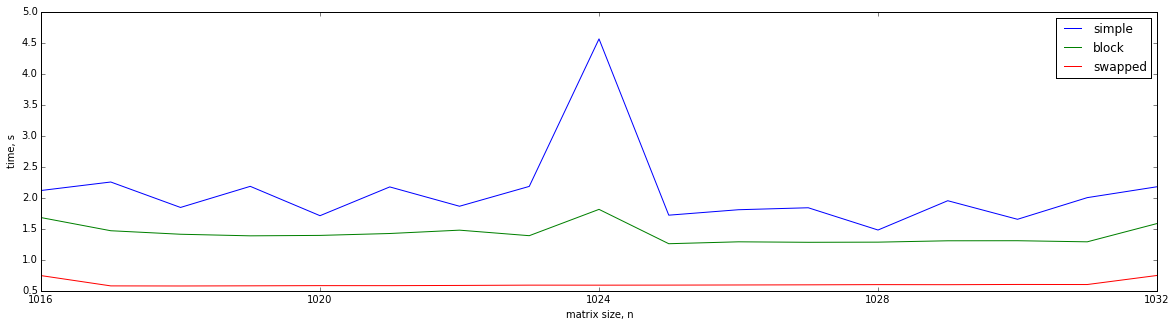

In [16]:
plot(small_block)

Кажется, что относительный скачок уменьшился, тем не менее, в каком-то виде он всё же есть
Это можно списать:<br>
&nbsp;&nbsp;&nbsp;&nbsp;1) На всякие мелкие погрешности<br>
&nbsp;&nbsp;&nbsp;&nbsp;2) Возможно мой кеш всё же не 8-канальный<br>
В любом случае уменьшать далее размер блока бесмысленно - т.к. это приведёт к тому, что кеш линия будет содержать лишь небольшую часть блока (вообще в неё вмещается 16 флоатов, а мы сейчас используем только 7 ячеек), а также к трате производительности на выполнение вложенных циклов малой длинны. Увеличение же размера блока, скорее приблизит нас к алгоритму прямого перемножения (со всеми соопутствующими проблемами)